# 210317 Find identical genomes

In [1]:
using JSON
using Mmap
using CSV
using Printf

In [2]:
using DataFrames
using FilePathsBase
using FilePathsBase: /
using PlotlyJS

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-18059965869080443018\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-11002455307037760753\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-18059965869080443018\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [3]:
using Midas
using Midas.Pairwise: npairs, iterpairs
using Midas.Overlaps: connected_components
using TriMatrices

## Setup

In [4]:
ENV["COLUMNS"] = 400

400

In [5]:
DATESTR = "210317"
NBNAME = "$DATESTR-find-identical-genomes"

"210317-find-identical-genomes"

In [6]:
infiles = Dict(
    :distances => p"../../data/intermediate/200727-find-overlaps/genome-pw-distances.raw-float32",
    :formatted => p"data-intermediate/210303-format-data/",
);

In [7]:
intermediate_out = p"data-intermediate" / NBNAME
isdir(intermediate_out) || mkdir(intermediate_out)

processed_out = p"data-processed" / NBNAME
isdir(processed_out) || mkdir(processed_out)

p"data-processed/210317-find-identical-genomes"

## Func defs

In [8]:
function minimum_by(f, itr)
    minv, rest = Iterators.peel(itr)
    minf = f(minv)
    
    for v in rest
        fv = f(v)
        if fv < minf
            minv = v
            minf = fv
        end
    end
    
    return minv
end

minimum_by (generic function with 1 method)

## Load data

### Database

In [9]:
genomes_df = DataFrame(CSV.File(infiles[:formatted] / "genomes-v1.1.csv"))
insertcols!(genomes_df, 1, :index => axes(genomes_df, 1))

ngenomes = nrow(genomes_df)

50752

In [10]:
species_df = DataFrame(CSV.File(infiles[:formatted] / "species-v1.2.csv"))
insertcols!(species_df, 1, :index => axes(species_df, 1))

nspecies = nrow(species_df)

1438

### Distances

In [11]:
pw_data = Mmap.mmap(open(infiles[:distances]), Vector{Float32}, (npairs(ngenomes),));

pw_dists = TriMatrix(TriSymmetric{false}(), ngenomes, pw_data);

## Find identical groups

In [12]:
zeropairs = [TriMatrices.lin2car(TriMatrices.TriLayout(pw_dists), i) for i in findall(==(0), pw_data)];

In [13]:
groups = sort!(connected_components(zeropairs), by=length, rev=true);

### Sanity checks

In [14]:
for group in groups
    # Check all genomes in group are same species
    s = genomes_df[group[1], :species_v12_idx1]
    @assert all(i -> genomes_df[i, :species_v12_idx1] == s, group)
    
    # Check all pairwise distances are zero
    @assert all(((i, j),) -> pw_dists[i, j] == 0, iterpairs(group))
end

### Summarize

In [15]:
groups_df = map(groups) do group
    sidx = genomes_df[group[1], :species_v12_idx1]
    srow = species_df[sidx, :]
    
    (
        ngenomes=length(group),
        sp_idx=sidx,
        sp_name=srow[:name],
        sp_ngenomes=srow[:ngenomes],
        frac_of_species=length(group) / srow[:ngenomes],
    )
end |> DataFrame;

In [16]:
sort(groups_df, :ngenomes, rev=true)

,ngenomes,sp_idx,sp_name,sp_ngenomes,frac_of_species
,Int64,Int64,String,Int64,Float64
1,135,982,Streptococcus pneumoniae,7099,0.0190168
2,60,982,Streptococcus pneumoniae,7099,0.00845189
3,55,439,Salmonella enterica,4650,0.011828
4,52,1302,Mycobacterium tuberculosis,3574,0.0145495
5,44,439,Salmonella enterica,4650,0.00946237
6,33,439,Salmonella enterica,4650,0.00709677
7,33,988,Streptococcus equi,243,0.135802
8,25,312,Legionella pneumophila,488,0.0512295
9,24,1302,Mycobacterium tuberculosis,3574,0.00671517


### Plot

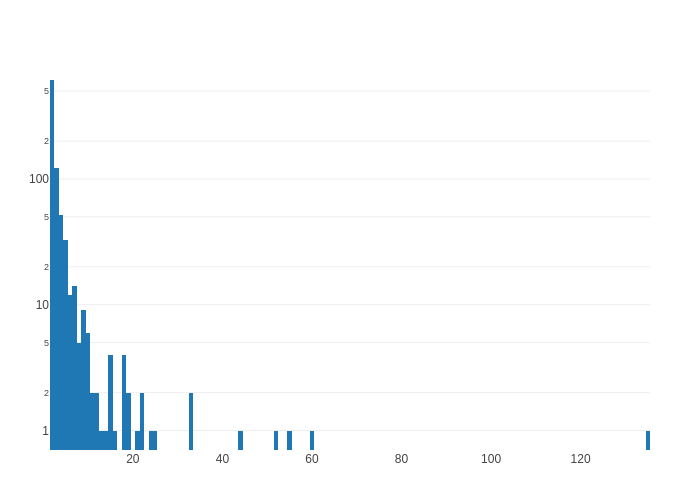

In [17]:
plot(histogram(x=length.(groups)), Layout(yaxis=attr(type=:log)))

## Pick exemplars

Chose one "exemplar" genome from each group to keep, discard the rest. There's not much information available to choose one over another, so just choose the one with the alphabetically first accession number (reasoning that it was probably added to RefSeq first and therefore might have the best quality metadata/annotations/curation).

In [18]:
exemplars = [
    minimum_by(i -> genomes_df[i, :accession], group)
    for group in groups
];

## Summary by species

In [19]:
species_summary_df = map(groupby(groups_df, :sp_idx)) do df
    ngroups = nrow(df)
    n_to_remove = sum(df[!, :ngenomes]) - ngroups
    
    sp_ngenomes = df[1, :sp_ngenomes]
    sp_needs_remove = sp_ngenomes - n_to_remove <= 1
    
    (
        sp_idx=df[1, :sp_idx],
        sp_name=df[1, :sp_name],
        sp_ngenomes=sp_ngenomes,
        ngroups=ngroups,
        n_to_remove=n_to_remove,
        frac_to_remove=n_to_remove / sp_ngenomes,
        sp_needs_remove=sp_needs_remove,
    )
end |> DataFrame

,sp_idx,sp_name,sp_ngenomes,ngroups,n_to_remove,frac_to_remove,sp_needs_remove
,Int64,String,Int64,Int64,Int64,Float64,Bool
1,982,Streptococcus pneumoniae,7099,64,284,0.0400056,0
2,439,Salmonella enterica,4650,161,580,0.124731,0
3,1302,Mycobacterium tuberculosis,3574,114,294,0.0822608,0
4,988,Streptococcus equi,243,34,119,0.489712,0
5,312,Legionella pneumophila,488,46,127,0.260246,0
6,381,Bordetella pertussis,327,4,27,0.0825688,0
7,983,Streptococcus pyogenes,249,12,33,0.13253,0
8,165,Francisella tularensis,95,6,24,0.252632,0
9,1201,Listeria monocytogenes,624,52,102,0.163462,0


In [20]:
sort(filter(row -> row[:sp_needs_remove], species_summary_df), :sp_name)

,sp_idx,sp_name,sp_ngenomes,ngroups,n_to_remove,frac_to_remove,sp_needs_remove
,Int64,String,Int64,Int64,Int64,Float64,Bool
1,407,Alkalihalobacillus akibai,2,1,1,0.5,1
2,409,Alkalihalobacillus hemicellulosilyticus,2,1,1,0.5,1
3,410,Alkalihalobacillus wakoensis,2,1,1,0.5,1
4,164,Candidatus Filomicrobium marinum,2,1,1,0.5,1
5,212,Candidatus Kinetoplastibacterium blastocrithidii,2,1,1,0.5,1
6,211,Candidatus Kinetoplastibacterium crithidii,2,1,1,0.5,1
7,253,Chryseobacterium oranimense,2,1,1,0.5,1
8,1029,Enterococcus malodoratus,2,1,1,0.5,1
9,1021,Enterococcus sulfureus,2,1,1,0.5,1


In [21]:
sort(filter(row -> !row[:sp_needs_remove], species_summary_df), :frac_to_remove, rev=true)

,sp_idx,sp_name,sp_ngenomes,ngroups,n_to_remove,frac_to_remove,sp_needs_remove
,Int64,String,Int64,Int64,Int64,Float64,Bool
1,620,Chlamydia muridarum,15,3,10,0.666667,0
2,299,Acetobacter pasteurianus,12,1,6,0.5,0
3,619,Chlamydia pneumoniae,10,1,5,0.5,0
4,213,Thermotoga maritima,6,1,3,0.5,0
5,1152,Parascardovia denticolens,4,1,2,0.5,0
6,1129,Clostridium pasteurianum,4,1,2,0.5,0
7,605,Rickettsia parkeri,4,1,2,0.5,0
8,988,Streptococcus equi,243,34,119,0.489712,0
9,167,Francisella orientalis,6,1,2,0.333333,0


In [22]:
sort(species_summary_df, :frac_to_remove, rev=true)

,sp_idx,sp_name,sp_ngenomes,ngroups,n_to_remove,frac_to_remove,sp_needs_remove
,Int64,String,Int64,Int64,Int64,Float64,Bool
1,620,Chlamydia muridarum,15,3,10,0.666667,0
2,597,Rickettsia typhi,3,1,2,0.666667,1
3,299,Acetobacter pasteurianus,12,1,6,0.5,0
4,619,Chlamydia pneumoniae,10,1,5,0.5,0
5,213,Thermotoga maritima,6,1,3,0.5,0
6,1152,Parascardovia denticolens,4,1,2,0.5,0
7,1129,Clostridium pasteurianum,4,1,2,0.5,0
8,605,Rickettsia parkeri,4,1,2,0.5,0
9,720,Hydrogenobacter thermophilus,2,1,1,0.5,1


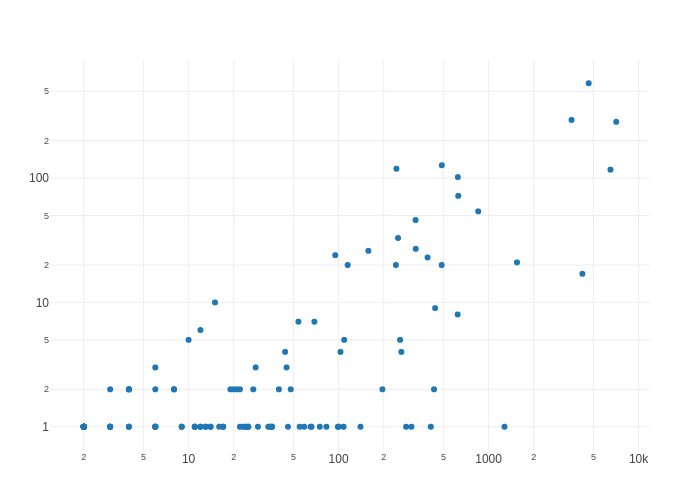

In [23]:
plot(
    scatter(
        species_summary_df,
        x=:sp_ngenomes,
        y=:n_to_remove,
        mode=:markers,
        text=:sp_name,
    ),
    Layout(
        xaxis=attr(
            type=:log
        ),
        yaxis=attr(
            type=:log
        ),
        hovermode=:closest,
    )
)

## Write Output

In [24]:
CSV.write(processed_out / "$DATESTR-identical-genome-groups.csv", groups_df)
CSV.write(processed_out / "$DATESTR-identical-genome-groups-by-species.csv", species_summary_df)

p"data-processed/210317-find-identical-genomes/210317-identical-genome-groups-by-species.csv"

In [25]:
let
    data = [
        Dict(:genome_indices => g, :exemplar => exemplars[i])
        for (i, g) in enumerate(groups)
    ]
    
    
    open(intermediate_out / "identical-genome-groups.json", "w") do f
        JSON.print(f, data)
    end
end